In [12]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, r2_score
import xgboost as xgb
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy.stats import f_oneway
import shap

In [2]:
death = pd.read_csv('/content/drug_overdose_death_data.csv')
gdp = pd.read_csv('/content/gdp_data.csv')
insurance = pd.read_csv('/content/health_insurance_data.csv')
dispensing = pd.read_csv('/content/opioid_dispensing_rate_data.csv')
unemployment = pd.read_csv('/content/unemployment_data.csv')
education = pd.read_csv('/content/education_data.csv')
poverty = pd.read_csv('/content/poverty_data.csv')

In [3]:
dispensing['County'] = dispensing['County'].str.replace(' County', '', regex=False)
poverty['County'] = poverty['County'].str.replace(' County', '', regex=False)

merged = pd.merge(death, gdp, on=['Year', 'State', 'County'], how='inner')
merged = pd.merge(merged, insurance, on=['Year', 'State', 'County'], how='inner')
merged = pd.merge(merged, dispensing, on=['Year', 'State', 'County'], how='inner')
merged = pd.merge(merged, unemployment, on=['Year', 'State', 'County'], how='inner')
merged = pd.merge(merged, education, on=['Year', 'State', 'County'], how='inner')
merged = pd.merge(merged, poverty, on=['Year', 'State', 'County'], how='inner')

merged.dropna(inplace=True)
merged.rename(
    columns = {'Rate (%)': 'Unemployment Rate (%)'}, inplace=True
)
merged['Poverty Estimate'] = merged['Poverty Estimate'].str.replace(',', '').astype(float)
merged.dtypes

,0
Year,int64
State,object
County,object
Drug Overdose Deaths,int64
GDP (USD),float64
Uninsured (%),float64
Opioid Dispensing Rate (per 100 persons),float64
Unemployment Rate (%),float64
Education Attainment (% of Bachelor's Degree or Higher),float64
Poverty Estimate,float64


In [4]:
merged

,Year,State,County,Drug Overdose Deaths,GDP (USD),Uninsured (%),Opioid Dispensing Rate (per 100 persons),Unemployment Rate (%),Education Attainment (% of Bachelor's Degree or Higher),Poverty Estimate
0,2020,Nebraska,Adams,0,1793509.0,10.2,48.3,4.08,25.6,3062.0
1,2020,Nebraska,Antelope,0,583630.0,11.2,40.5,2.53,18.0,647.0
5,2020,Nebraska,Boone,0,432605.0,7.8,12.9,2.37,19.0,435.0
6,2020,Nebraska,Box Butte,0,559546.0,12.8,63.7,4.68,17.7,1002.0
7,2020,Nebraska,Boyd,0,110434.0,9.7,34.9,3.17,18.3,235.0
...,...,...,...,...,...,...,...,...,...,...
623,2023,West Virginia,Webster,0,133462.0,7.7,90.4,4.95,12.6,2092.0
624,2023,West Virginia,Wetzel,107,1069209.0,6.3,27.0,6.78,13.5,2388.0
625,2023,West Virginia,Wirt,0,79511.0,7.5,16.8,5.99,16.2,882.0
626,2023,West Virginia,Wood,530,3717276.0,7.9,51.8,3.97,22.9,11200.0


In [5]:
independent_variables = ['GDP (USD)', 'Uninsured (%)', 'Opioid Dispensing Rate (per 100 persons)', 'Unemployment Rate (%)', "Education Attainment (% of Bachelor's Degree or Higher)", 'Poverty Estimate']
dependent_variable = 'Drug Overdose Deaths'

X = merged[independent_variables]
y = merged[dependent_variable]

In [6]:
folds = [
    {'train': [2020], 'test': [2021]},
    {'train': [2020, 2021], 'test': [2022]},
    {'train': [2020, 2021, 2022], 'test': [2023]},
]

Evaluation function

In [7]:
def run(model, scaler=None):
  mae, r2, corr, all_actual, all_predicted = [], [], [], [], []

  for fold in folds:
    train = merged[merged['Year'].isin(fold['train'])]
    test = merged[merged['Year'].isin(fold['test'])]

    X_train, y_train = train[independent_variables], train[dependent_variable]
    X_test, y_test = test[independent_variables], test[dependent_variable]

    # use scaler only for KNN
    if scaler is not None:
      X_train = scaler.fit_transform(X_train)
      X_test = scaler.transform(X_test)

    model.fit(X_train, y_train)
    predicted = model.predict(X_test)

    mae.append(mean_absolute_error(y_test, predicted))
    r2.append(r2_score(y_test, predicted))
    corr.append(np.corrcoef(y_test, predicted)[0, 1])

    all_actual.extend(y_test)
    all_predicted.extend(predicted)

  print(f'{model.__class__.__name__} MAE per fold: {mae}')
  print(f'{model.__class__.__name__} average MAE : {np.mean(mae)}')
  print(f'\n{model.__class__.__name__} R2 per fold: {r2}')
  print(f'{model.__class__.__name__} average R2 : {np.mean(r2)}')
  print(f'\n{model.__class__.__name__} Pearson correlation per fold: {corr}')
  print(f'{model.__class__.__name__} average Pearson correlation : {np.mean(corr)}\n')

  return np.array(all_actual), np.array(all_predicted), pd.DataFrame(X_train, columns=independent_variables)

Visualization function

In [8]:
def plot_predictions(y_actual, y_predicted, model):
  plt.figure(figsize=(9, 6))
  plt.scatter(y_actual, y_predicted, alpha=0.5)
  plt.xlabel('Actual Values')
  plt.ylabel('Predicted Values')
  plt.title(f'Actual vs. Predicted Values for {model.__class__.__name__}')

  min_val = min(min(y_actual), min(y_predicted))
  max_val = max(max(y_actual), max(y_predicted))
  plt.plot([min_val, max_val], [min_val, max_val], linestyle='--', color='red', label='Perfect Prediction')
  plt.legend()
  plt.grid(True, linestyle='--', alpha=0.7)
  plt.show()

Model Evaluation & Visualization

XGBRegressor MAE per fold: [77.14439392089844, 48.18930435180664, 42.040000915527344]
XGBRegressor average MAE : 55.79123306274414

XGBRegressor R2 per fold: [0.7502703070640564, 0.8772690892219543, 0.910374641418457]
XGBRegressor average R2 : 0.8459713459014893

XGBRegressor Pearson correlation per fold: [np.float64(0.9251294993440556), np.float64(0.9425797832849641), np.float64(0.956169889306525)]
XGBRegressor average Pearson correlation : 0.9412930573118482



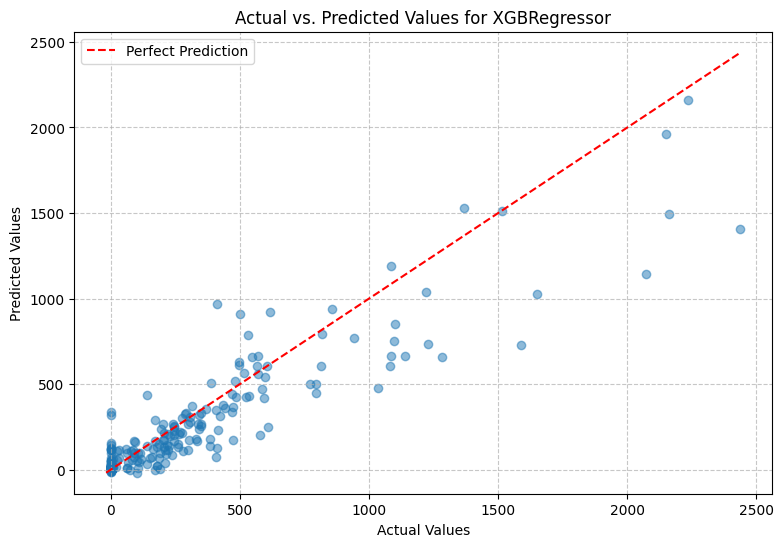

------------------------------------------------
LinearRegression MAE per fold: [105.24282286819374, 106.48202956003446, 101.90416278077998]
LinearRegression average MAE : 104.54300506966939

LinearRegression R2 per fold: [0.5968660603667999, 0.6100398436376455, 0.5789498284086498]
LinearRegression average R2 : 0.5952852441376985

LinearRegression Pearson correlation per fold: [np.float64(0.7758453633469022), np.float64(0.7823170436755175), np.float64(0.7622063406671705)]
LinearRegression average Pearson correlation : 0.7734562492298633



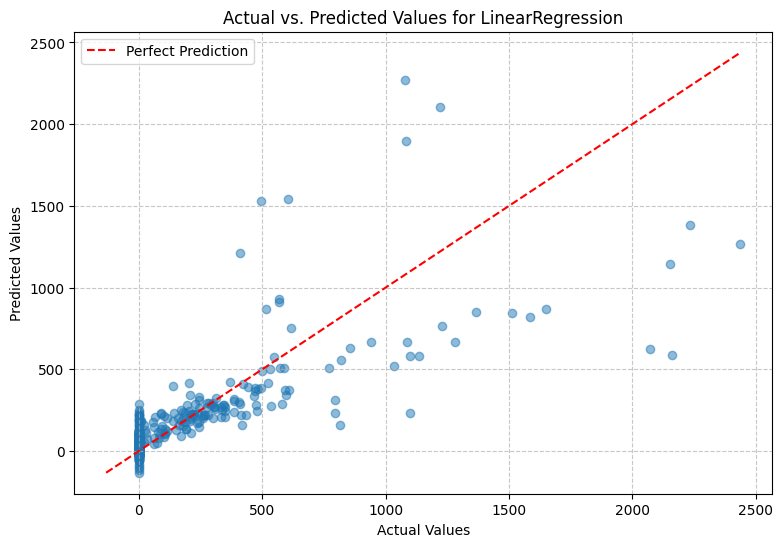

------------------------------------------------
KNeighborsRegressor MAE per fold: [81.62264737515504, 48.373008212110115, 39.247884141448694]
KNeighborsRegressor average MAE : 56.414513242904626

KNeighborsRegressor R2 per fold: [0.7786943161183372, 0.9243936199684887, 0.9454899884187863]
KNeighborsRegressor average R2 : 0.8828593081685373

KNeighborsRegressor Pearson correlation per fold: [np.float64(0.8930021773361019), np.float64(0.9615113407568877), np.float64(0.9737085974436346)]
KNeighborsRegressor average Pearson correlation : 0.9427407051788746



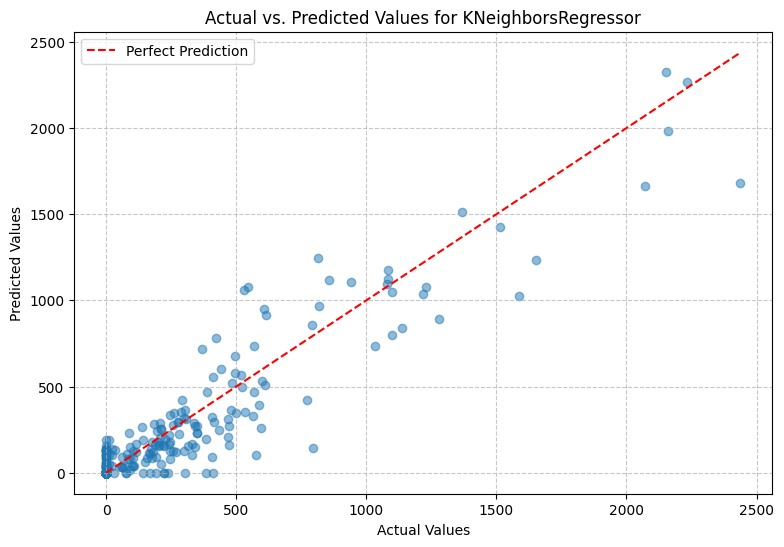

In [9]:
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=100,
    learning_rate=0.1,
    random_state=42
)
y_actual_xgb, y_predicted_xgb, X_train_xgb = run(xgb_model)
plot_predictions(y_actual_xgb, y_predicted_xgb, xgb_model)

print("------------------------------------------------")

lr_model = LinearRegression()
y_actual_lr, y_predicted_lr, X_train_lr = run(lr_model)
plot_predictions(y_actual_lr, y_predicted_lr, lr_model)

print("------------------------------------------------")

knn_model = KNeighborsRegressor(n_neighbors=2, weights='distance')
y_actual_knn, y_predicted_knn, X_train_knn = run(knn_model, StandardScaler())
plot_predictions(y_actual_knn, y_predicted_knn, knn_model)

Hypothesis testing using ANOVA and Tukey HSD

In [23]:
mae_xgb = [77.14, 48.19, 42.04]
mae_lr = [105.2, 106.5, 101.9]
mae_knn = [81.62, 48.37, 39.25]

data = pd.DataFrame({
    'MAE': mae_xgb + mae_lr + mae_knn,
    'Model': ['XGB'] * len(mae_xgb) + ['LR'] * len(mae_lr) + ['KNN'] * len(mae_knn)
})

print('ANOVA Test')
f_stat, p_valeu = f_oneway(mae_xgb, mae_lr, mae_knn)
print(f'F-statistic: {f_stat}')
print(f'p-value: {p_valeu}\n')

tukey_results = pairwise_tukeyhsd(data['MAE'], data['Model'], alpha=0.05)
print(tukey_results)

ANOVA Test
F-statistic: 8.238310078170304
p-value: 0.019022199507433127

 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower    upper  reject
-----------------------------------------------------
   KNN     LR    48.12   0.03   5.8448 90.3952   True
   KNN    XGB  -0.6233 0.9989 -42.8986 41.6519  False
    LR    XGB -48.7433 0.0284 -91.0186 -6.4681   True
-----------------------------------------------------


SHAP function

In [34]:
def plot_shap(model, X_train):
  name = model.__class__.__name__

  if name == 'XGBRegressor':
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_train)
  elif name == 'LinearRegression':
    explainer = shap.LinearExplainer(model, X_train)
    shap_values = explainer.shap_values(X_train)
  elif name == 'KNeighborsRegressor':
    explainer = shap.KernelExplainer(model.predict, X_train)
    shap_values = explainer.shap_values(X_train)

  mean_abs_shap = np.abs(shap_values).mean(axis=0)
  df = pd.DataFrame({
      'Feature': X_train.columns,
      'Mean |SHAP|': mean_abs_shap
  })
  df = df.sort_values(by='Mean |SHAP|', ascending=False).reset_index(drop=True)
  print(df)

  shap.summary_plot(shap_values, X_train, plot_type='bar', show=False)
  plt.title(f'SHAP Summary Plot for {name}')
  plt.xlabel('Mean |SHAP|')
  plt.show()

SHAP analysis

                                             Feature  Mean |SHAP|
0                                   Poverty Estimate   188.806793
1                                      Uninsured (%)    19.194483
2           Opioid Dispensing Rate (per 100 persons)    18.753775
3                                          GDP (USD)    14.030620
4  Education Attainment (% of Bachelor's Degree o...     9.203507
5                              Unemployment Rate (%)     7.149820


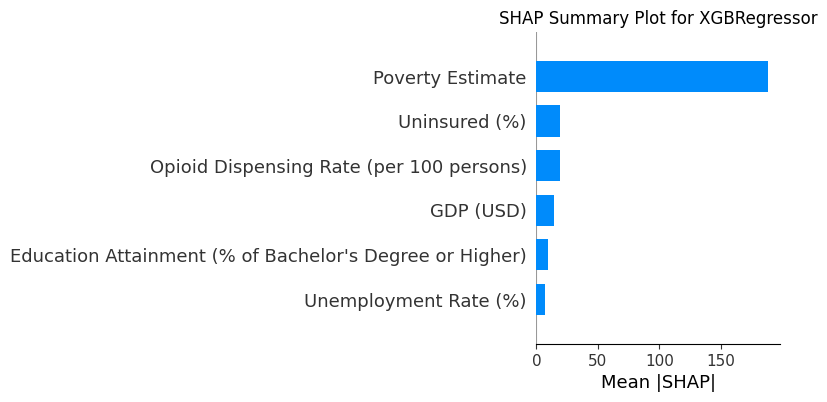

                                             Feature  Mean |SHAP|
0                                   Poverty Estimate   183.521911
1                                          GDP (USD)    56.551773
2                                      Uninsured (%)    22.409334
3  Education Attainment (% of Bachelor's Degree o...    19.289342
4                              Unemployment Rate (%)    12.483061
5           Opioid Dispensing Rate (per 100 persons)     7.714127


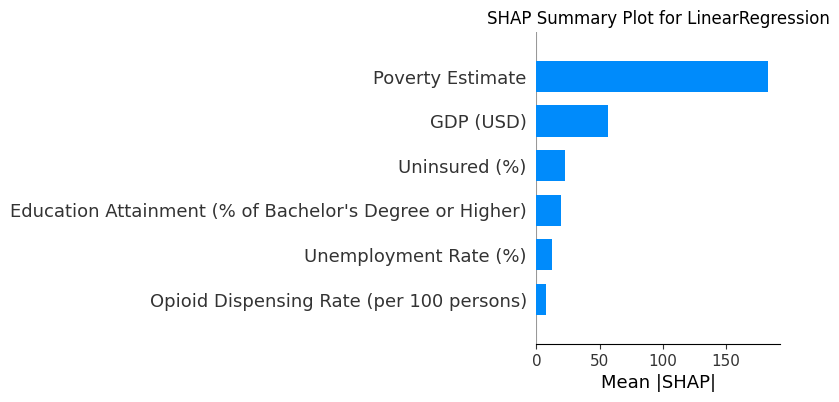

  0%|          | 0/435 [00:00<?, ?it/s]

                                             Feature  Mean |SHAP|
0                                   Poverty Estimate   122.888565
1                                          GDP (USD)    35.394974
2                              Unemployment Rate (%)    28.631054
3                                      Uninsured (%)    26.736936
4  Education Attainment (% of Bachelor's Degree o...    23.633150
5           Opioid Dispensing Rate (per 100 persons)    20.847102


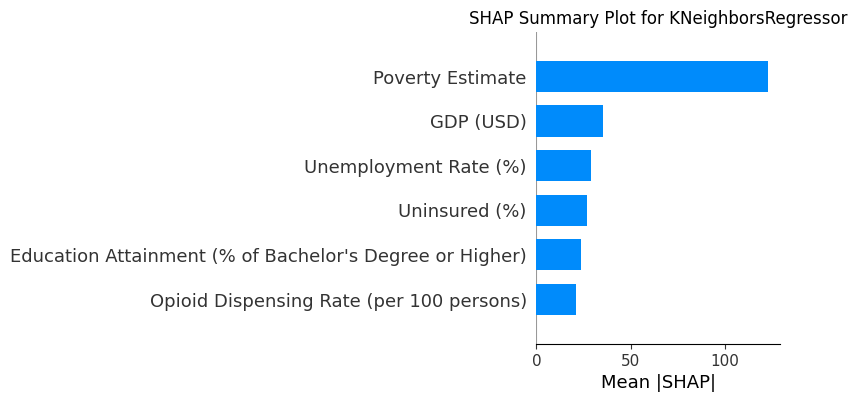

In [35]:
plot_shap(xgb_model, X_train_xgb)
plot_shap(lr_model, X_train_lr)
plot_shap(knn_model, X_train_knn)